In [43]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline
path_data = './data/'

In [44]:
#torchvision = utility to get common datasets
train = torchvision.datasets.CIFAR10(root=path_data, train=True, download =True)
test = torchvision.datasets.CIFAR10(root=path_data, train = False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [45]:
type(train)

torchvision.datasets.cifar.CIFAR10

In [46]:
train.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [47]:
#PIL image HxWxC 32x32x3 (0-255)
train.data.shape


(50000, 32, 32, 3)

In [48]:
train.data[0].shape

(32, 32, 3)

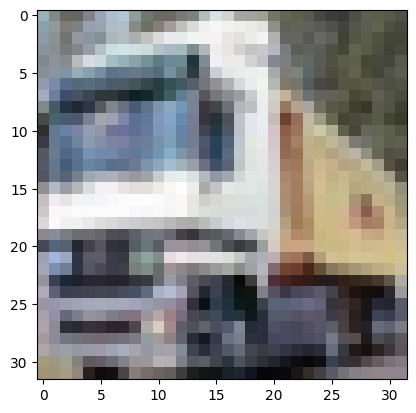

In [49]:
#convert from data to image
plt.imshow(train.data[1], interpolation='nearest')
plt.show()

In [50]:
#transform for faster processing and normalise to prevent oscillations (input-mean)/stdv
#can be combined using composed transform
cifar_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #transforms.ToTensor already rescales to 0-1, otherwise it would be (127.5,127.5,127.5),(some_std_here)
])

train.transform = cifar_transform
test.transform = cifar_transform

train.transforms = torchvision.datasets.vision.StandardTransform(cifar_transform)
test.transforms = torchvision.datasets.vision.StandardTransform(cifar_transform)

print(train.transform)  
print('\n######\n')
print(train.transforms)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

######

StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [51]:
# two types of datasets in pytorch
# map-style [Dataset Class] and iterable-style [IteableDataset Class], CIFAR10 is a map-style
# DataLoader class combines both classes

trainloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False) #no need to shuffle when evaluating
# its Data L oader not Data l oader

In [52]:
#look at a batch in raw form
train_iter = iter(trainloader)
#images, labels = train_iter.next() #deprecated syntax since pytorch 1.13
images, labels = next(train_iter)
print(images[1])

tensor([[[ 0.2078, -0.0118, -0.1765,  ..., -0.2863, -0.3176, -0.3804],
         [ 0.0980,  0.1373, -0.0196,  ..., -0.2471, -0.3961, -0.4431],
         [ 0.0980,  0.0902, -0.0980,  ..., -0.3804, -0.4667, -0.4745],
         ...,
         [ 0.3725,  0.2235,  0.2078,  ..., -0.6706, -0.5216, -0.2706],
         [ 0.2941,  0.2235,  0.2471,  ..., -0.1922, -0.0353,  0.0275],
         [ 0.2784,  0.2392,  0.2784,  ...,  0.1216,  0.1216,  0.1216]],

        [[ 0.3882,  0.0745, -0.1843,  ..., -0.2549, -0.2941, -0.3647],
         [ 0.2549,  0.2000, -0.0196,  ..., -0.2235, -0.3725, -0.4275],
         [ 0.2157,  0.1451, -0.0980,  ..., -0.3569, -0.4510, -0.4588],
         ...,
         [ 0.3098,  0.2078,  0.2549,  ..., -0.7333, -0.5843, -0.3490],
         [ 0.2078,  0.1922,  0.2627,  ..., -0.2706, -0.1059, -0.0510],
         [ 0.1608,  0.1608,  0.2235,  ...,  0.0431,  0.0510,  0.0431]],

        [[ 0.4667,  0.0667, -0.2549,  ..., -0.4431, -0.4431, -0.4510],
         [ 0.3255,  0.2078, -0.0745,  ..., -0

In [53]:
images[1].shape

torch.Size([3, 32, 32])

In [54]:
print(labels[1])
#idx 9 = truck

tensor(9)


 frog truck truck  deer


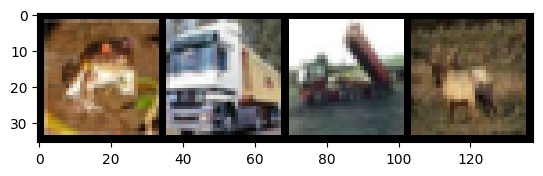

In [55]:
# plot whats in the image tensor (after normalising)
# images is an tensor array B(atch size) x C(hannels) x H x W 
# currently the values are between -1 and 1 and imshow needs between 0 and 1
# torchvision.utils.make_grid() automatically makes a film-strip style image

def plot_images(images, labels):
    img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    #normalize true shifts -1,1 to 0,1
    np_img = img_grid.numpy().transpose(1,2,0) #reshape axes to imshow compatible format
    plt.imshow(np_img)

d_class2idx = train.class_to_idx
d_idx2class = dict(zip(d_class2idx.values(),d_class2idx.keys()))

plot_images(images,labels)
print(' '.join('%5s' % d_idx2class[int(labels[j])]for j in range(len(images))))

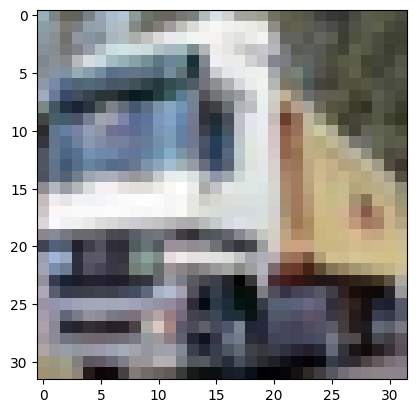

In [56]:
plot_images(images[1],labels[1])

In [57]:
# was expecting Truck not Dog but Shuffle = True in dataloader
# setting it to False to see effect of normalisation, seems no equal

In [58]:
#Making the CNN

import torch.nn as nn
import torch.nn.functional as F


# defining a class inheriting from nn.Module and has 2 methods __init__ and forward()
# input to a nn.Conv2d layer is a shape (nSamples x H x W)
###################################################################
# first type of layers is a nn.Conv2D() with 3 parameters:
#   1. in_channels: number of channels, 3 in this case (RGB)
#   2. out_channels: number of convolutional filters/features you would like
#   3. kernel_size: size of the square filter: 3 = 3x3, 2 = 2x2 etc.
#   4. Other parameters: stride, padding, dilation etc.
####################################################################
# second type of layer is the nn.MaxPool2d()
# with compulsary parameter kernel_size (poolwindow size)
####################################################################
# third a simple linear layer in the form of y=WX+b
# followd by a ReLU activations in the network F.relu

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(3,6,5) #ouputs 6 channels, kernel is 5x5
        self.pool = nn.MaxPool2d(2,2) # define once, use multiple times
        self.conv_2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120) # 16 channels of 5x5 size
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10) # 10 classes as output

    def forward(self,x):
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = x.view(-1, 16*5*5) #flatten: np.reshape = new object, view = reference
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #no activation on final layer because we are gonna use cross entropy which expects raw logits as the final layer
        return x


In [59]:
class NetSequential(nn.Module):
    def __init__(self):
        super().__init__()
        self.mynn = nn.Sequential(

        nn.Conv2d(3,6,5), #ouputs 6 channels, kernel is 5x5
        nn.ReLU(),
        nn.MaxPool2d(2,2), 

        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        #  x = x.view(-1, 16*5*5) #flatten: np.reshape = new object, view = reference
        nn.Flatten(),
        nn.Linear(16*5*5,120), # 16 channels of 5x5 size
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10) # 10 classes as output

        )

    def forward(self, x):
        logits = self.mynn(x)
        return logits  #"logits" refers to unnormalized log-probabilities


In [60]:
net =  Net()

In [63]:
# Loss and optimization
import torch.optim as optim

CrossEntropyLossCriterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
epochs = 500

In [64]:
# Train function
epochresults = []

for epoch in range(epochs):
    
    running_loss = 0.0

    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])


        #forward pass
        outputs = net.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epochresults.append(epoch_loss)

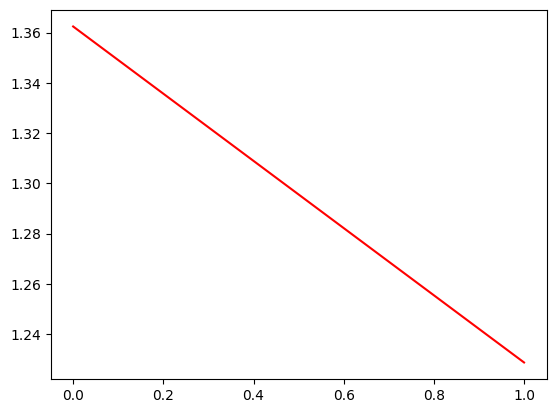

In [65]:

plt.plot( epochresults, 'red')
plt.show()